# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import LabelEncoder
import pickle
import boto3
import os
from dotenv import load_dotenv

In [3]:
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy

In [5]:
load_dotenv()

True

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [7]:
def get_session_student():
    session = boto3.session.Session()
 
    return session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
    )

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [22]:
tracks = pd.read_parquet("tracks.parquet")

In [23]:
catalog_names = pd.read_parquet("catalog_names.parquet")

In [24]:
interactions = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.
* Нужно ли изменить тип идентификаторов?
* Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

### tracks (Данные о треках)
* track_id — идентификатор музыкального трека;
* albums — список идентификаторов альбомов, содержащих трек;
* artists — список идентификаторов исполнителей трека;
* genres — список идентификаторов жанров, к которым принадлежит трек.

In [6]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [7]:
tracks.sample(3)

,track_id,albums,artists,genres
883695,72798786,[12565238],[61429],[50]
990174,96216714,[19700453],[10172835],"[11, 20]"
788083,61240199,"[9537522, 10624989, 10625059, 12225096, 125029...",[3024812],[11]


In [8]:
# тип массивов
print(type(tracks.loc[0, 'albums']))
print(type(tracks.loc[0, 'artists']))
print(type(tracks.loc[0, 'genres']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
# тип элементов массивов
print(type(tracks.loc[0, 'albums'][0]))
print(type(tracks.loc[0, 'artists'][0]))
print(type(tracks.loc[0, 'genres'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [10]:
# функция для подсчета количества элементов
def len_list(l):
    return l.shape[0]

In [11]:
# вычислим длины массивов
tracks['n_albums'] = tracks['albums'].apply(len_list)
tracks['n_artists'] = tracks['artists'].apply(len_list)
tracks['n_genres'] = tracks['genres'].apply(len_list)

In [12]:
print('Кол-во записей нулевой длины в поле albums:', tracks[tracks['n_albums']==0]['track_id'].count())
print('Кол-во записей нулевой длины в поле artists:', tracks[tracks['n_artists']==0]['track_id'].count())
print('Кол-во записей нулевой длины в поле genres:', tracks[tracks['n_genres']==0]['track_id'].count())

Кол-во записей нулевой длины в поле albums: 18
Кол-во записей нулевой длины в поле artists: 15369
Кол-во записей нулевой длины в поле genres: 3687


In [13]:
tracks = tracks.query('n_albums > 0 and n_artists > 0 and n_genres > 0').reset_index(drop=True)

In [14]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980977 entries, 0 to 980976
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   track_id   980977 non-null  int64 
 1   albums     980977 non-null  object
 2   artists    980977 non-null  object
 3   genres     980977 non-null  object
 4   n_albums   980977 non-null  int64 
 5   n_artists  980977 non-null  int64 
 6   n_genres   980977 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 52.4+ MB


In [15]:
print(f'Доля удаленных записей: {np.round(100 * (1000000 - 980977) / 1000000, 2)}%')

Доля удаленных записей: 1.9%


Проблемв в tracks присутствуют:
* пропусков нет, но есть записи с нулевым количеством элементов (самое большое их количество в поле artists - но это всего-лишь 1,9% от общего их числа и лучше удалить такие треки из рекомендательной базы чтобы улучшить ее качество;
* типы корректные.

### catalog_names (Имена артистов, названия альбомов, треков и жанров )
* id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
* type — тип идентификатора;
* name — имя (название) каталожной единицы.

In [16]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [17]:
catalog_names.sample(3)

,id,type,name
121037,1898816,album,50 x Chopin
1336296,36284179,track,Sun In The Winter
298345,4865820,album,U Lied to Me


In [18]:
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [19]:
# почему-то тут не выдается информация о количестве записей, проверим по-другому
print('Кол-во пропусков в поле albums:', np.sum(catalog_names['id'].isnull()))
print('Кол-во пропусков в поле type:', np.sum(catalog_names['type'].isnull()))
print('Кол-во пропусков в поле name:', np.sum(catalog_names['name'].isnull()))

Кол-во пропусков в поле albums: 0
Кол-во пропусков в поле type: 0
Кол-во пропусков в поле name: 0


In [20]:
print('Кол-во нулей в поле id:', catalog_names[catalog_names['id']==0]['id'].count())
print('Кол-во пустых записей в поле track_id:', catalog_names[catalog_names['type']=='']['id'].count())
print('Кол-во пустых записей в поле track_seq:', catalog_names[catalog_names['name']=='']['id'].count())

Кол-во нулей в поле id: 1
Кол-во пустых записей в поле track_id: 0
Кол-во пустых записей в поле track_seq: 0


In [21]:
# скореее всего, ноль в в поле id корректный, т.к. он всего один

Проблемв в catalog_names отсутствуют:
* пропусков нет;
* типы корректные.

### interactions (Данные о том, какие пользователи прослушали тот или иной трек)
* user_id — идентификатор пользователя,
* track_id — идентификатор музыкального трека,
* track_seq — номер места трека в истории пользователя,
* started_at — дата начала прослушивания трека.

In [22]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [23]:
interactions.sample(3)

,user_id,track_id,track_seq,started_at
272,331099,29637702,273,2022-12-14
112,607720,50284640,113,2022-05-10
55,1023683,91993183,56,2022-12-19


In [24]:
# почему-то тут не выдается информация о количестве записей, проверим по-другому
print('Кол-во пропусков в поле user_id:', np.sum(interactions['user_id'].isnull()))
print('Кол-во пропусков в поле track_id:', np.sum(interactions['track_id'].isnull()))
print('Кол-во пропусков в поле track_seq:', np.sum(interactions['track_seq'].isnull()))
print('Кол-во пропусков в поле started_at:', np.sum(interactions['started_at'].isnull()))

Кол-во пропусков в поле user_id: 0
Кол-во пропусков в поле track_id: 0
Кол-во пропусков в поле track_seq: 0
Кол-во пропусков в поле started_at: 0


In [25]:
print('Кол-во нулей в поле user_id:', interactions[interactions['user_id']==0]['user_id'].count())
print('Кол-во нулей в поле track_id:', interactions[interactions['track_id']==0]['user_id'].count())
print('Кол-во нулей в поле track_seq:', interactions[interactions['track_seq']==0]['user_id'].count())
print('Кол-во нулей в поле started_at:', interactions[interactions['started_at']==0]['user_id'].count())

Кол-во нулей в поле user_id: 26
Кол-во нулей в поле track_id: 0
Кол-во нулей в поле track_seq: 0
Кол-во нулей в поле started_at: 0


Проблемв в interactions присутствуют:
* пропусков нет, но есть нули в поле user_id - видимо, пропуски были заполнены нулями;
* индексы повторялись;
* типы корректные.

In [26]:
interactions = interactions.query('user_id != 0').reset_index(drop=True)

In [27]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222629872 entries, 0 to 222629871
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.7 GB


In [28]:
print(f'Доля удаленных записей: {np.round(100 * (222629898 - 222629872) / 222629898, 6)}%')

Доля удаленных записей: 1.2e-05%


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

* Типы идентификаторов корректные, в замене не нуждаются.
* Треки с отсутствующими записями были удалены.
* Записи о взаимодействиях с нулевыми идентификаторами пользовтаелей были удалены.

In [29]:
tracks.to_parquet("tracks_fix.parquet")
catalog_names.to_parquet("catalog_names_fix.parquet")
interactions.to_parquet("interactions_fix.parquet")

# === ЭТАП 2 ===

In [46]:
tracks = pd.read_parquet("tracks_fix.parquet")
catalog_names = pd.read_parquet("catalog_names_fix.parquet")
interactions = pd.read_parquet("interactions_fix.parquet")

# EDA

### Распределение количества прослушанных треков.

<Axes: >

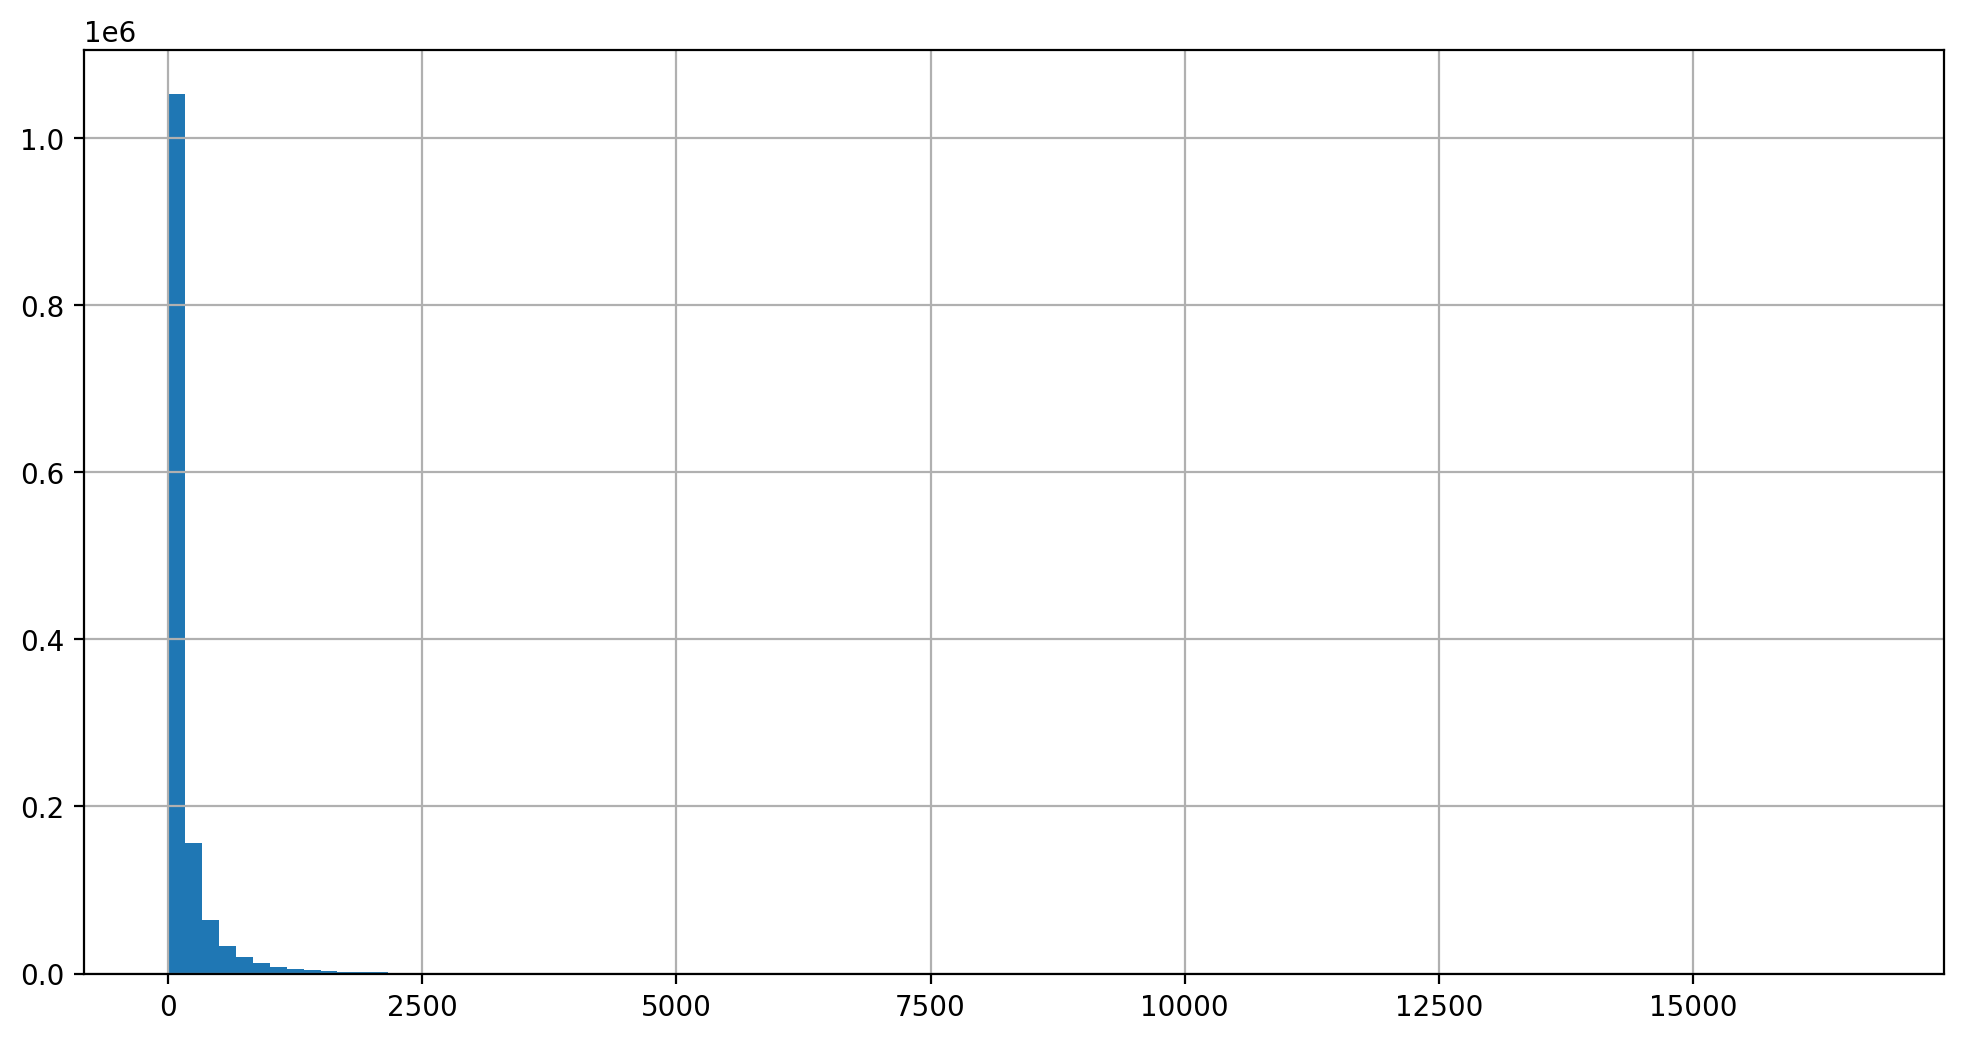

In [30]:
# трактую как - прослушанных треков каждым пользователем
interactions.groupby("user_id").agg(num=("track_id", "count"))['num'].hist(bins=100, figsize=(12, 6))

<Axes: >

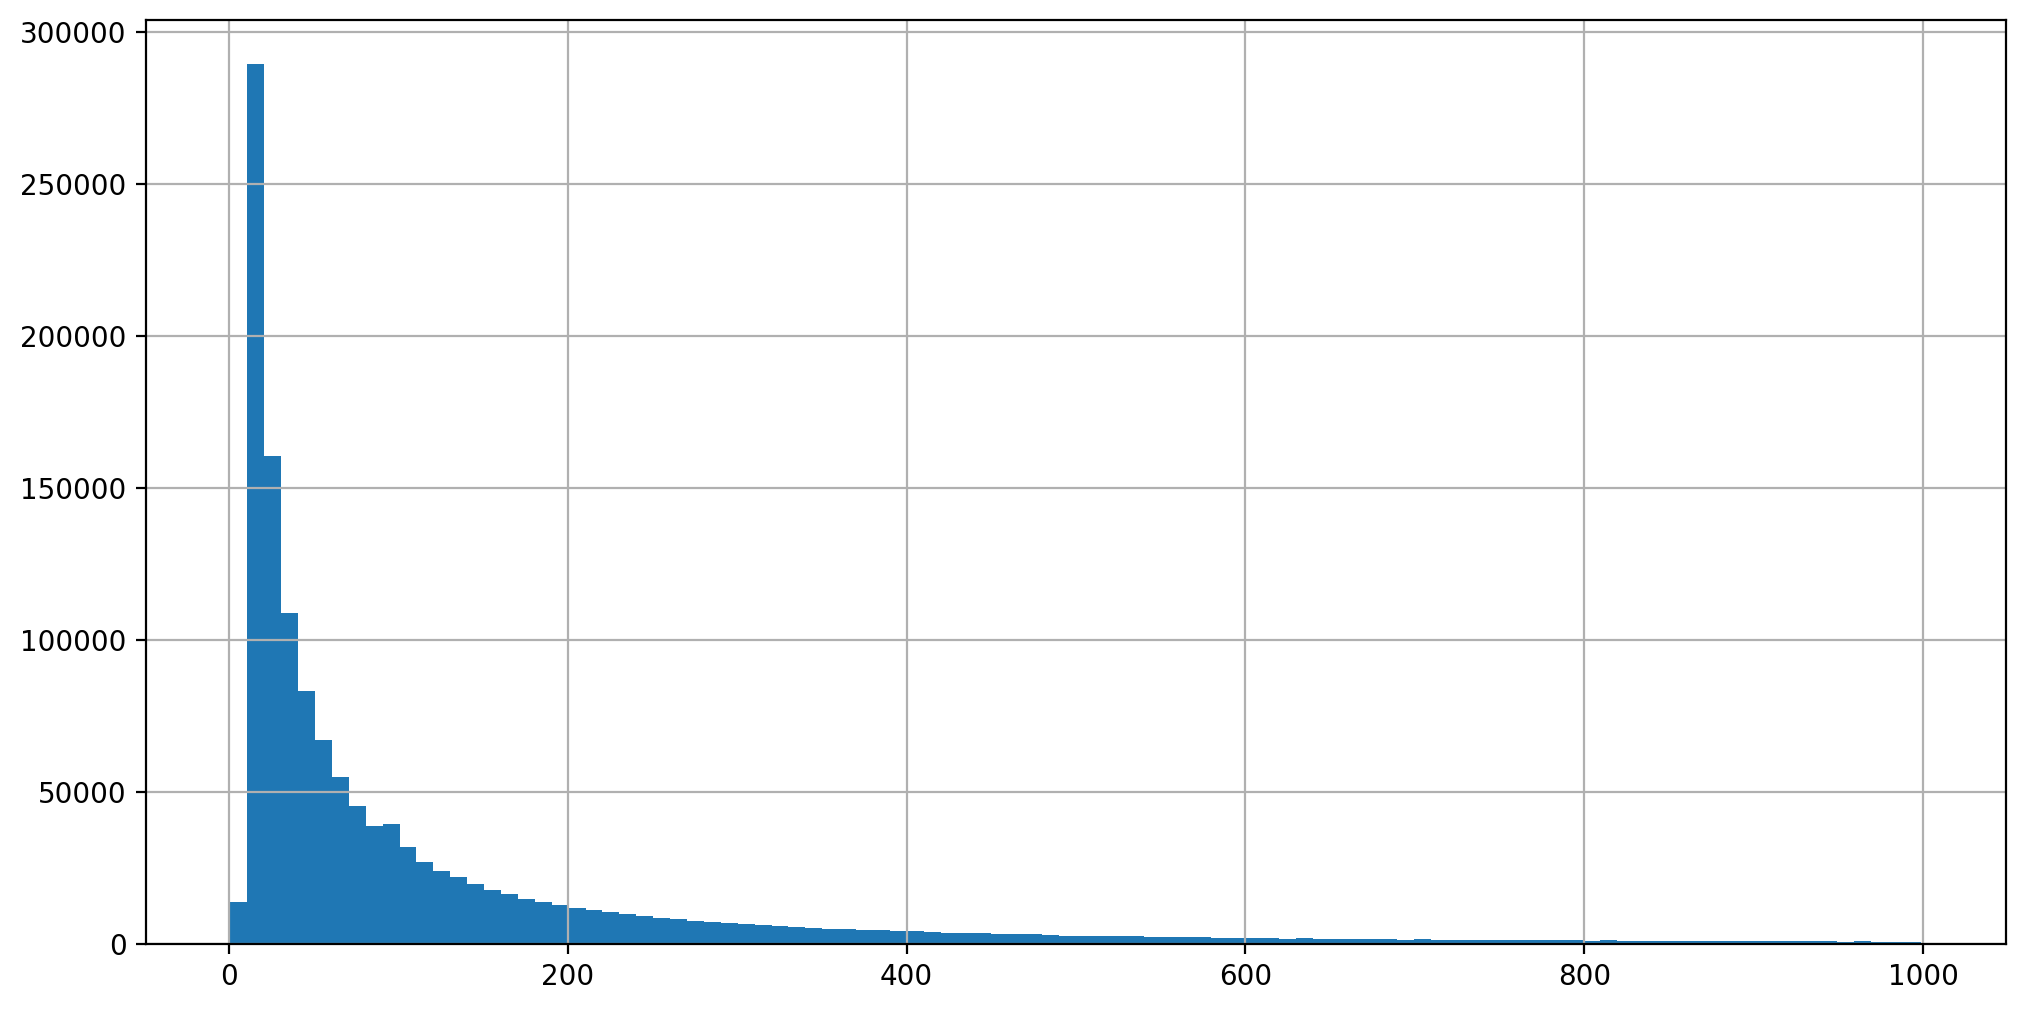

In [31]:
# видно, что основная часть распределения сосредоточена до 1000 - посмотрим боле побробно
interactions.groupby("user_id").agg(num=("track_id", "count")).query('num < 1000')['num'].hist(bins=100, figsize=(12, 6))

In [32]:
# т.е. в основном пользователи слушают одно и то же 

### Наиболее популярные треки

In [33]:
popular_tracks = interactions.groupby("track_id").agg(nunique=("user_id", "nunique"))

In [34]:
popular_tracks = popular_tracks.sort_values(by='nunique', ascending=False)

In [35]:
top_10_popular_tracks = popular_tracks[:10]

In [36]:
top_10_popular_tracks = top_10_popular_tracks.merge(tracks.drop(['n_albums', 'n_artists', 'n_genres'], axis=1), on='track_id', how='left')

In [37]:
# TOP-10 популярных трэков
top_10_popular_tracks

,track_id,nunique,albums,artists,genres
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],"[13, 14, 102]"
1,33311009,106921,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]"
2,178529,101924,"[18113, 21924, 21940, 488052, 10009799]",[36800],"[41, 47]"
3,35505245,99490,"[4431303, 20559909]","[4611844, 588511]","[3, 75]"
4,65851540,86670,[10692414],[1554548],"[11, 20]"
5,24692821,86246,"[2888516, 3523463, 3530199, 4333848, 4420934, ...",[1194096],[70]
6,32947997,85886,"[4019560, 4172930, 4172931, 5614201, 5933975]",[381067],[11]
7,51241318,85244,"[5239478, 13040087, 13131618, 15177310, 154524...","[1802873, 3135644, 9012818]",[74]
8,795836,85042,"[88770, 296297, 297576, 302579, 303469, 558376...",[680],"[11, 14, 102]"
9,45499814,84748,"[6109461, 7094821, 7152451, 7170954, 7285586, ...",[5007577],"[11, 20]"


In [38]:
for i in range(top_10_popular_tracks.shape[0]):
    print(f'Информация по треку на месте N-{i+1} в TOP-10:')
    track_id = top_10_popular_tracks.loc[i, 'track_id']
    print('-- Трэк:', catalog_names.query('id==@track_id and type=="track"')['name'].tolist()[0])
    
    artists = top_10_popular_tracks.loc[i, 'artists']
    artists_list = []
    for artist in artists:
        artists_list.append(catalog_names.query('id==@artist and type=="artist"')['name'].tolist()[0])
    print('-- Исполнители:', ', '.join(artists_list))

    genres = top_10_popular_tracks.loc[i, 'genres']
    genres_list = []
    for genre in genres:
        genres_list.append(catalog_names.query('id==@genre and type=="genre"')['name'].tolist()[0])
    print('-- Жанры:', ', '.join(genres_list))
    
    print('')    

Информация по треку на месте N-1 в TOP-10:
-- Трэк: Smells Like Teen Spirit
-- Исполнители: Nirvana
-- Жанры: alternative, rock, allrock

Информация по треку на месте N-2 в TOP-10:
-- Трэк: Believer
-- Исполнители: Imagine Dragons
-- Жанры: rock, allrock

Информация по треку на месте N-3 в TOP-10:
-- Трэк: Numb
-- Исполнители: Linkin Park
-- Жанры: numetal, metal

Информация по треку на месте N-4 в TOP-10:
-- Трэк: I Got Love
-- Исполнители: Miyagi & Эндшпиль, Рем Дигга
-- Жанры: rusrap, rap

Информация по треку на месте N-5 в TOP-10:
-- Трэк: Юность
-- Исполнители: Dabro
-- Жанры: pop, ruspop

Информация по треку на месте N-6 в TOP-10:
-- Трэк: Way Down We Go
-- Исполнители: KALEO
-- Жанры: indie

Информация по треку на месте N-7 в TOP-10:
-- Трэк: Shape of You
-- Исполнители: Ed Sheeran
-- Жанры: pop

Информация по треку на месте N-8 в TOP-10:
-- Трэк: In The End
-- Исполнители: Tommee Profitt, Fleurie, Mellen Gi
-- Жанры: rnb

Информация по треку на месте N-9 в TOP-10:
-- Трэк: Shap

### Наиболее популярные жанры

In [101]:
# снчала для удобства сделаем отдельный каталог жанров
genres_df = catalog_names[catalog_names['type']=='genre'].reset_index(drop=True)

In [102]:
genres_df.to_parquet("genres.parquet")

In [4]:
genres_df = pd.read_parquet("genres.parquet")

In [5]:
top_gengres = interactions[::4]

In [6]:
top_gengres = top_gengres.merge(tracks.drop(['n_albums', 'n_artists', 'n_genres'], axis=1), on='track_id', how='left')

In [7]:
top_gengres.sample(3).T

,21729481,50768695,26166539
user_id,537472,1254350,647002
track_id,56920157,12979046,37780971
track_seq,321,672,2521
started_at,2022-11-09 00:00:00,2022-07-04 00:00:00,2022-06-01 00:00:00
albums,[8477535],[1410664],[4797875]
artists,[6286764],"[73364, 191678, 9787967]","[998286, 3038432]"
genres,"[6, 70]","[127, 335]","[44, 75]"


In [8]:
#top_gengres = top_gengres.explode('genres').merge(genres_df.drop(['count'], axis=1), left_on = 'genres', right_on='id', how='left')
top_gengres = top_gengres.drop(['track_id', 'track_seq', 'started_at', 'artists'], axis=1).explode('genres').groupby("genres").agg(nunique=("user_id", "nunique"))

In [9]:
top_gengres.sample(3).T

genres,67,58,1484
nunique,12463,7402,8633


In [10]:
top_10_gengres = top_gengres.sort_values(by='nunique', ascending=False).reset_index(drop=False)[:10]

In [14]:
del top_gengres

In [11]:
top_10_gengres

,genres,nunique
0,11,1116929
1,20,805049
2,75,803011
3,102,777342
4,16,692662
5,68,660465
6,3,659368
7,14,552042
8,2,488248
9,44,485353


In [12]:
top_10_gengres = top_10_gengres.merge(genres_df.drop(['count'], axis=1), left_on = 'genres', right_on='id', how='left')

In [13]:
top_10_gengres

,genres,nunique,type,name
0,11,1116929,genre,pop
1,20,805049,genre,ruspop
2,75,803011,genre,rap
3,102,777342,genre,allrock
4,16,692662,genre,dance
5,68,660465,genre,electronics
6,3,659368,genre,rusrap
7,14,552042,genre,rock
8,2,488248,genre,rusrock
9,44,485353,genre,foreignrap


Анализ был проведен по каждому 4му взаимодействию, т.к. не хватало ресурсов вистуальной машины. По итогам, в порядке убывания популярность жанров: поп, русский поп, рэп, рок (чем allrock отличается от rock??? есть подозрения на ошибку с схеме классификации жанров), танцевальные, электронные, русский рэп, рок, русский рок, зарубежный рэп.

### Треки, которые никто не прослушал

In [25]:
# Я заново прогрузил все датасеты, т.к. после фильтрации что-то могло выпасть
listen_set = set(interactions['track_id'].unique())

In [26]:
all_tracks_set = set(tracks['track_id'].unique())

In [27]:
print('Всего треков:', len(all_tracks_set))
print('Из них прослушано:', len(listen_set))
print('Непрослушанных треков:', len(all_tracks_set) - len(listen_set))

Всего треков: 1000000
Из них прослушано: 1000000
Непрослушанных треков: 0


In [28]:
# На всякий случай проверим эти множества  на разность
print(len(all_tracks_set.difference(listen_set)))
print(len(listen_set.difference(all_tracks_set)))

0
0


Получается, что таких треков, которые никто не прослушал - нет.

In [33]:
# Но, если взять отфильтрованные датасеты, то во взаимодействиях окажутся треки, которые были выброшены из базы
listen_set = set(interactions['track_id'].unique())
all_tracks_set = set(tracks['track_id'].unique())
print('Всего треков:', len(all_tracks_set))
print('Из них прослушано:', len(listen_set))
print('Непрослушанных треков:', len(all_tracks_set) - len(listen_set))

Всего треков: 980977
Из них прослушано: 1000000
Непрослушанных треков: -19023


In [34]:
print(len(all_tracks_set.difference(listen_set)))
print(len(listen_set.difference(all_tracks_set)))

0
19023


In [35]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222629872 entries, 0 to 222629871
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.7 GB


In [123]:
# Эти взаимодействия тоже надо удалить
interactions = interactions.query('track_id in @all_tracks_set').reset_index(drop=True)

In [124]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222184423 entries, 0 to 222184422
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.7 GB


In [38]:
# удалено записей
222629871 - 222184422

445449

In [125]:
interactions.to_parquet("interactions_fix.parquet")

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [29]:
## подготовим такие же датасеты по трэкам, альбомам и артистам, как ранее по жанрам
albums_df = catalog_names[catalog_names['type']=='album'].reset_index(drop=True)
artists_df = catalog_names[catalog_names['type']=='artist'].reset_index(drop=True)
tracks_df = catalog_names[catalog_names['type']=='track'].reset_index(drop=True)

albums_df.to_parquet("albums.parquet")
artists_df.to_parquet("artists.parquet")
tracks_df.to_parquet("tracks.parquet")

In [47]:
tracks = tracks.merge(tracks_df.drop('type', axis=1), left_on = 'track_id', right_on='id', how="left").drop('id', axis=1)

In [49]:
tracks.sample(3).T

,980601,973281,457794
track_id,100850438,96910559,32038134
albums,[21210026],[19904718],[3898329]
artists,[9651868],[5674435],[41126]
genres,"[11, 20]",[11],"[3, 75]"
n_albums,1,1,1
n_artists,1,1,1
n_genres,2,1,2
name,Заколдованные дети,Camarob,Какой-То Вася


In [65]:
tracks = pd.read_parquet("items.parquet")

In [66]:
# добавим артистов
tracks_artists = tracks.explode('artists')

In [67]:
tracks_artists = tracks_artists.merge(artists_df.drop('type', axis=1), left_on = 'artists', right_on='id', how="left").drop('id', axis=1)

In [68]:
tracks_artists = tracks_artists.groupby('track_id', as_index=False).agg({'name_y': lambda x: list(x)})

In [69]:
tracks = tracks.merge(tracks_artists, on = 'track_id', how="left")

In [71]:
tracks.sample(3).T

,298169,15793,333921
track_id,19279559,97193,21754306
albums,[2168169],[9025],[2497303]
artists,[3134981],"[2927, 37679, 100732, 708610]","[421967, 9170]"
genres,[13],"[44, 75]","[23, 69]"
n_albums,1,1,1
n_artists,1,4,2
n_genres,1,2,2
name,My Religion,There He Go,"Mozart: Violin Concerto No. 1 in B-Flat Major,..."
name_y,[Troy Baker],"[Fabolous, Paul Cain, Red Cafe, Freck Billiona...","[Vilde Frang, Wolfgang Amadeus Mozart]"


In [73]:
del tracks_artists

In [74]:
tracks = tracks.rename(columns={'name': 'track_name', 'name_y': 'artists_names'})

In [75]:
# добавим альбомы
tracks_albums = tracks.explode('albums')
tracks_albums = tracks_albums.merge(albums_df.drop('type', axis=1), left_on = 'albums', right_on='id', how="left").drop('id', axis=1)
tracks_albums = tracks_albums.groupby('track_id', as_index=False).agg({'name': lambda x: list(x)})
tracks = tracks.merge(tracks_albums, on = 'track_id', how="left")
tracks = tracks.rename(columns={'name': 'albums_names'})
del tracks_albums

In [95]:
tracks.sample(5).T

,663666,900920,440153,880221,840389
track_id,47469779,78354320,30896409,74312827,69022533
albums,"[6448808, 12225871]","[14001064, 14030285]","[3738803, 3738982, 3933278, 10684136, 10876066...","[12985181, 14170810, 14171298]","[11501600, 19412019]"
artists,[896910],"[1181, 15409]",[75628],[4576380],[6406482]
genres,[68],[51],[11],"[68, 332]","[14, 102]"
n_albums,2,2,8,3,2
n_artists,1,2,1,1,1
n_genres,1,1,1,2,2
track_name,Molodost Prostit,Patience,Hard To Forget Ya,Offender,Paint It Black
artists_names,[XS Project],"[Nas, Damian Marley]",[Britney Spears],[Dimension],[Leo Moracchioli]
albums_names,"[Molodost Prostit, Hard Bass in da Gas Mask]","[Distant Relatives, Distant Relatives]","[Glory, Glory, Glory, Glory, Glory, Glory, Glo...","[Offender, Organ, Organ]","[Leo Metal, Vol. 28, Paint It Black]"


Одни и те же альбомы имеют разные идентификаторы. Возможно, они издавались в разные годы, но такой информации нет в каталоге, а значит это разделение нам бесполезно. Это может стать проблемой - возможно надо будет провести унификацию альбомов.

In [104]:
# добавим жанры
tracks_genres = tracks.explode('genres')
tracks_genres = tracks_genres.merge(genres_df.drop('type', axis=1), left_on = 'genres', right_on='id', how="left").drop('id', axis=1)
tracks_genres = tracks_genres.groupby('track_id', as_index=False).agg({'name': lambda x: list(x)})
tracks = tracks.merge(tracks_genres, on = 'track_id', how="left")
tracks = tracks.rename(columns={'name': 'genres_names'})
del tracks_genres

In [108]:
tracks.sample(5).T

,122148,3137,95303,410481,619053
track_id,2197708,17264,847465,28307046,43356017
albums,[217550],"[1511, 2122, 85703, 213393, 2507414, 3290997, ...","[95478, 95479]",[3385444],[5765038]
artists,"[87889, 89233]",[7851],[49469],[4313173],"[111980, 413023]"
genres,[11],"[11, 14, 102]",[13],"[3, 75]","[19, 325]"
n_albums,1,10,2,1,1
n_artists,2,1,1,1,2
n_genres,1,3,1,2,2
track_name,Brighton Beach,My Girl,Redesign Me,пизда,Гравитация
artists_names,"[Télépopmusik, Angela McCluskey]",[The Mamas & The Papas],[VersaEmerge],[макулатура],"[Интарс Бусулис, Елена Ваенга]"
albums_names,[Angel Milk],"[Gold, Colour Collection, California Dreamin' ...","[Fixed At Zero, Fixed At Zero]",[девять рассказов],[1+1 (Дуэты)]


In [110]:
# для того, чтобы модель срабатывала правильно, надо преобразовать идентификаторы треков
labelencoder = LabelEncoder()
tracks['new_id'] = labelencoder.fit_transform(tracks['track_id'])

In [112]:
tracks.head()

,track_id,albums,artists,genres,n_albums,n_artists,n_genres,track_name,artists_names,albums_names,genres_names,new_id
0,26,"[3, 2490753]",[16],"[11, 21]",2,1,2,Complimentary Me,[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",0
1,38,"[3, 2490753]",[16],"[11, 21]",2,1,2,Momma's Boy,[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",1
2,135,"[12, 214, 2490809]",[84],[11],3,1,1,Atticus,[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],2
3,136,"[12, 214, 2490809]",[84],[11],3,1,1,24 Hours,[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],3
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],10,1,1,Don't Upset The Rhythm (Go Baby Go),[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",[pop],4


In [134]:
tracks = tracks.rename(columns={'new_id': 'item_id'})

In [135]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980977 entries, 0 to 980976
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   track_id       980977 non-null  int64 
 1   albums         980977 non-null  object
 2   artists        980977 non-null  object
 3   genres         980977 non-null  object
 4   n_albums       980977 non-null  int64 
 5   n_artists      980977 non-null  int64 
 6   n_genres       980977 non-null  int64 
 7   track_name     980977 non-null  object
 8   artists_names  980977 non-null  object
 9   albums_names   980977 non-null  object
 10  genres_names   980977 non-null  object
 11  item_id        980977 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 89.8+ MB


In [136]:
tracks.to_parquet("items.parquet")

In [121]:
# Сохранение модели labelencoder в файл
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(labelencoder, f)

In [ ]:
# Загрузка модели из файла
#with open('label_encoder.pkl', 'rb') as f:
#    labelencoder = pickle.load(f)

In [119]:
interactions = pd.read_parquet("interactions_fix.parquet")

In [126]:
# теперь надо, чтобы во взаимодействиях тоже токие же идентификаторы появились
interactions['new_track_id'] = labelencoder.transform(interactions['track_id'])

In [127]:
interactions.head()

,user_id,track_id,track_seq,started_at,new_track_id
0,1,24417,1,2022-06-11,4341
1,1,108208,2,2022-06-13,18039
2,1,108209,3,2022-06-13,18040
3,1,592642,4,2022-06-15,61577
4,1,628687,5,2022-06-15,64323


In [129]:
interactions.drop('track_id', axis=1, inplace=True)

In [131]:
interactions = interactions.rename(columns={'new_track_id': 'item_id'})

In [132]:
interactions.head()

,user_id,track_seq,started_at,item_id
0,1,1,2022-06-11,4341
1,1,2,2022-06-13,18039
2,1,3,2022-06-13,18040
3,1,4,2022-06-15,61577
4,1,5,2022-06-15,64323


In [133]:
interactions.to_parquet("events.parquet")

А user_id перекодировать нет никакого смысла

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [46]:
s3 = get_session_student()
bucket_name = os.getenv("S3_BUCKET_NAME")

In [145]:
s3.upload_file("items.parquet", bucket_name, 'recsys/data/items.parquet')
s3.upload_file("events.parquet", bucket_name, 'recsys/data/events.parquet')

In [152]:
response = s3.list_objects_v2(Bucket=bucket_name)

In [154]:
# Проверяем, есть ли объекты в бакете
if 'Contents' in response:
    for obj in response['Contents'][-2:]:
        print(f"Имя объекта: {obj['Key']}, Размер: {obj['Size']} байт")
else:
    print("Бакет пуст или не существует.")

Имя объекта: recsys/data/events.parquet, Размер: 1307546120 байт
Имя объекта: recsys/data/items.parquet, Размер: 75470489 байт


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [157]:
items = tracks
events = interactions

In [156]:
%who

LabelEncoder	 albums_df	 all_tracks_set	 artists_df	 boto3	 bucket_name	 catalog_names	 f	 genres_df	 
get_session_student	 interactions	 labelencoder	 listen_set	 load_dotenv	 logging	 not_listen_set	 np	 obj	 
os	 pd	 pickle	 plt	 response	 s3	 s3_client	 top_10_gengres	 tqdm	 
tracks	 tracks_df	 


In [158]:
del albums_df, all_tracks_set, artists_df, catalog_names, genres_df, listen_set, not_listen_set, response, top_10_gengres, tracks, tracks_df

Для продолжения начиная с этого места надо произвести импорт библиотек и подгрузить подготовленные датафреймы

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [ ]:
items = pd.read_parquet("items.parquet")

In [ ]:
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбейте данные на тренировочную и тестовую выборки: в тренировочную отнесите все данные до 16 декабря 2022 года (не включительно)

In [159]:
print(events['started_at'].min())
print(events['started_at'].max())

2022-01-01 00:00:00
2022-12-31 00:00:00


In [163]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")
print(train_test_global_time_split_date)
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
print(len(train_test_global_time_split_idx))

2022-12-16 00:00:00
222184423


In [169]:
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [24]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [25]:
# количество пользователей, которые есть и в train, и в test
common_users = list(set(users_train.to_list()).intersection(set(users_test.to_list())))
print(len(users_train), len(users_test), len(common_users))

1342106 782025 751365


In [26]:
# холодные пользователи (которые есть в тесте, но нет в трейне)
cold_users = list(set(users_test.to_list()).difference(set(users_train.to_list())))
print(len(cold_users)) 

30660


In [171]:
events_train.to_parquet("events_train.parquet")

In [172]:
events_test.to_parquet("events_test.parquet")

Рассчитайте рекомендации нескольких типов, сохраните каждый тип в своём файле, в персональном S3-бакете по пути recsys/recommendations/:
* топ популярных — в top_popular.parquet;
* персональные (при помощи ALS) — в personal_als.parquet;
* похожие треки, или i2i (при помощи ALS) — в similar.parquet.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [8]:
items = pd.read_parquet("items.parquet")

In [9]:
events_test = pd.read_parquet("events_test.parquet")

In [10]:
events_train = pd.read_parquet("events_train.parquet")

In [7]:
# возьмем 1 последний месяц трейна
top_pop_start_date = pd.to_datetime("2022-11-16").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(users=("user_id", "nunique")).reset_index()

In [9]:
# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm"]] = scaler.fit_transform(
    item_popularity[["users"]]
)

In [10]:
# вычисляем popularity_score, как скор популярности (рейтинга нет в данных)
item_popularity["popularity_score"] = item_popularity["users_norm"]

In [11]:
# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by='popularity_score',ascending=False)

In [50]:
item_popularity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811934 entries, 756433 to 650284
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_id           811934 non-null  int64  
 1   users             811934 non-null  int64  
 2   users_norm        811934 non-null  float64
 3   popularity_score  811934 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 31.0 MB


In [12]:
item_popularity.head(10)

,item_id,users,users_norm,popularity_score
756433,923941,23606,1.000000,1.000000
607168,770472,23093,0.978267,0.978267
751635,919064,22918,0.970854,0.970854
652823,818090,22682,0.960856,0.960856
733999,901224,22401,0.948951,0.948951
761279,928830,22244,0.942300,0.942300
721667,888735,20101,0.851515,0.851515
723532,890614,19985,0.846600,0.846600
535322,693863,18613,0.788477,0.788477
720385,887422,18051,0.764669,0.764669


In [51]:
# добавим в итемсы популярность раз нет рейтинга
items = items.merge(item_popularity.drop(['users', 'users_norm'], axis=1), how='left', on='item_id')

In [52]:
items.sample(5).T

,863236,137896,686638,955049,182350
track_id,72080212,2774888,50726632,91110186,5336286
albums,"[12355005, 12400479]","[35541, 297720, 298151, 410627]",[7028167],[18094006],[587131]
artists,"[96527, 79998, 3750819, 3145469, 3309117, 7383]",[82939],[125306],[4939330],[35915]
genres,"[21, 138]","[102, 319]","[13, 54]","[3, 75]","[38, 47]"
n_albums,2,4,1,1,1
n_artists,6,1,1,1,1
n_genres,2,2,2,2,2
track_name,A Güiro,"Another Brick In The Wall, Part 1",Fantasy Land,Тембр,Left Hand Black
artists_names,"[Randy, Toño Rosario, Jon Z, Kiko El Crazy, Ra...",[Pink Floyd],[Our Last Night],[Mufasah],[Danzig]
albums_names,"[A Güiro, 10: 22]","[The Wall, The Wall, The Discovery Boxset, The...",[Fantasy Land],[VOLK LIFE],[Danzig III: How The Gods Kill]


In [53]:
items.to_parquet("items.parquet")

In [60]:
# выбираем первые 100 айтемов
top_k_pop_items = item_popularity.head(100)

In [61]:
top_k_pop_items.reset_index(drop=True, inplace=True)

In [62]:
# добавляем информацию о треках
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["track_name", "artists_names", "albums_names", "genres_names"]], on="item_id")

In [63]:
top_k_pop_items.sample(3).T

,37,98,54
item_id,568869,577122,962876
users,13337,9425,12208
users_norm,0.564965,0.399237,0.517136
popularity_score,0.564965,0.399237,0.517136
track_name,In My Mind,Зелёные волны,МАЛИНОВАЯ ЛАДА
artists_names,"[Dynoro, Gigi D'Agostino]",[Zivert],[GAYAZOV$ BROTHER$]
albums_names,"[In My Mind, In My Mind, Dance Hits 2019 - Sum...",[Сияй],[МАЛИНОВАЯ ЛАДА]
genres_names,[dance],"[pop, ruspop]","[pop, ruspop]"


In [64]:
with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "popularity_score", "track_name", "artists_names", "albums_names", "genres_names"]])

,item_id,popularity_score,track_name,artists_names,albums_names,genres_names
0,923941,1.000000,Птичка,[HammAli & Navai],[Птичка],"[pop, ruspop]"
1,770472,0.978267,Blinding Lights,[The Weeknd],"[Blinding Lights, After Hours, After Hours, Af...",[rnb]
2,919064,0.970854,Федерико Феллини,[Galibri & Mavik],[Федерико Феллини],"[pop, ruspop]"
3,818090,0.960856,Юность,[Dabro],[Юность],"[pop, ruspop]"
4,901224,0.948951,Rampampam,[Minelli],"[Rampampam, Rampampam]",[dance]
5,928830,0.942300,Я в моменте,"[Джарахов, Markul]",[Я в моменте],"[rusrap, rap]"
6,888735,0.851515,Astronaut In The Ocean,[Masked Wolf],"[Astronaut In The Ocean, Astronomical]","[foreignrap, rap]"
7,890614,0.846600,Горький вкус,[Султан Лагучев],"[Горький вкус, Горячие Хиты Кавказа 2]","[folk, caucasian]"
8,693863,0.788477,bad guy,[Billie Eilish],"[WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?, 202...",[indie]
9,887422,0.764669,Венера-Юпитер,[Ваня Дмитриенко],[Венера-Юпитер],"[pop, ruspop]"


In [71]:
cold_users = set(cold_users)

In [72]:
cold_users_events_with_recs = events_test.query("user_id in @cold_users").merge(top_k_pop_items, on="item_id", how="left")

In [78]:
cold_user_items_no_pop_idx = cold_users_events_with_recs["popularity_score"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_pop_idx] \
    [["item_id", "popularity_score"]] 

In [79]:
cold_user_recs.sample(3)

,item_id,popularity_score
1066286,962078,0.761788
617941,631410,0.512434
940497,843542,0.459437


In [80]:
top_k_pop_items.to_parquet("top_popular.parquet")

In [81]:
s3.upload_file("top_popular.parquet", bucket_name, 'recsys/recommendations/top_popular.parquet')

In [82]:
response = s3.list_objects_v2(Bucket=bucket_name)
# Проверяем, есть ли объекты в бакете
if 'Contents' in response:
    for obj in response['Contents'][-3:]:
        print(f"Имя объекта: {obj['Key']}, Размер: {obj['Size']} байт")
else:
    print("Бакет пуст или не существует.")

Имя объекта: recsys/data/events.parquet, Размер: 1307546120 байт
Имя объекта: recsys/data/items.parquet, Размер: 75470489 байт
Имя объекта: recsys/recommendations/top_popular.parquet, Размер: 29142 байт


# Персональные

Рассчитаем персональные рекомендации.

In [84]:
events_test = events_test.merge(items[['item_id', 'popularity_score']], how='left', on='item_id')
events_train = events_train.merge(items[['item_id', 'popularity_score']], how='left', on='item_id')

In [85]:
events_test.sample(3)

,user_id,track_seq,started_at,item_id,popularity_score
2387398,237129,7,2022-12-26,518647,0.008346
8733900,867543,23,2022-12-22,742105,0.092057
5929641,588669,51,2022-12-28,659357,0.004279


In [86]:
events_train.sample(3)

,user_id,track_seq,started_at,item_id,popularity_score
38989860,257053,133,2022-08-17,315117,0.004321
70823715,467233,129,2022-11-15,42668,0.024529
74787035,493895,934,2022-08-01,760165,0.079898


In [87]:
events_test.to_parquet("events_test.parquet")

In [88]:
events_train.to_parquet("events_train.parquet")

In [11]:
events_train = events_train.rename(columns={'popularity_score': 'rating'})
events_test = events_test.rename(columns={'popularity_score': 'rating'})

In [12]:
# используем Reader из библиотеки surprise для преобразования событий (events)
# в формат, необходимый surprise
# тк ресурсов не хватает то сделаем децимацию обучающих данных с шагом 8
reader = Reader(rating_scale=(0, 1))
surprise_train_set = Dataset.load_from_df(events_train[['user_id', 'item_id', 'rating']][::8], reader)
surprise_train_set = surprise_train_set.build_full_trainset()

In [13]:
# Сохранение модели reader в файл
with open('reader.pkl', 'wb') as f:
    pickle.dump(reader, f)

In [14]:
# инициализируем модель
svd_model = SVD(n_factors=100, random_state=0)

# обучаем модель
svd_model.fit(surprise_train_set)

In [15]:
# Сохранение модели svd_model в файл
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

In [16]:
surprise_test_set = list(events_test[['user_id', 'item_id', 'rating']][::4].itertuples(index=False))
# получаем рекомендации для тестовой выборки
svd_predictions = svd_model.test(surprise_test_set)

In [17]:
rmse = accuracy.rmse(svd_predictions)
mae = accuracy.mae(svd_predictions)
                     
print(rmse, mae)

RMSE: nan
MAE:  nan
nan nan


In [18]:
svd_predictions[:10]

[Prediction(uid=3, iid=899851, r_ui=0.5520864223681423, est=1, details={'was_impossible': False}),
 Prediction(uid=4, iid=927898, r_ui=0.005973310739250159, est=1, details={'was_impossible': False}),
 Prediction(uid=4, iid=940739, r_ui=0.03397585257360729, est=1, details={'was_impossible': False}),
 Prediction(uid=4, iid=977374, r_ui=0.02410506248676128, est=1, details={'was_impossible': False}),
 Prediction(uid=5, iid=516404, r_ui=0.13467485702181742, est=1, details={'was_impossible': False}),
 Prediction(uid=9, iid=743507, r_ui=0.0014403728023723787, est=1, details={'was_impossible': False}),
 Prediction(uid=9, iid=941603, r_ui=0.26689260749841137, est=1, details={'was_impossible': False}),
 Prediction(uid=10, iid=640960, r_ui=0.013641177716585469, est=1, details={'was_impossible': False}),
 Prediction(uid=10, iid=676343, r_ui=0.05422579961872485, est=1, details={'was_impossible': False}),
 Prediction(uid=11, iid=911621, r_ui=0.14403728023723786, est=1, details={'was_impossible': Fal

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.